<font size=6>Example: guizhou_traffic_prediction</font>

<font size=2>`FeatureStore` is a model-agnostic tool aiming to help data scientists and algorithm engineers get rid of tiring data storing and merging tasks.
<br> `FeatureStore` not only work on single-dimension data such as classification and prediction, but also work on time-series data.
<br> After collecting data, all you need to do is config several straight-forward .yml files, then you can focus on models/algorithms and leave all exhausting preparation to `FeatureStore`.</font>

<font size=4> Here we present guizhou traffic prediction mission as traditional ML demo.</font>

In [5]:
import sys
sys.path.append('/Users/zhao123456/Desktop/gitlab/f2ai')

##### Import packages

In [6]:
import os
import zipfile
import tempfile
import pandas as pd
import numpy as np
import pmdarima as pm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from pmdarima.model_selection import train_test_split
from aie_feast.common.sampler import GroupFixednbrSampler
from aie_feast.common.utils import get_bucket_from_oss_url
from aie_feast.featurestore import FeatureStore

##### Download demo project files from OSS

In [7]:
download_from = "oss://aiexcelsior-shanghai-test/xyz_test_data/guizhou_traffic.zip"
save_path = '/tmp/'
save_dir = tempfile.mkdtemp(prefix=save_path)
bucket, key = get_bucket_from_oss_url(download_from)
dest_zip_filepath = os.path.join(save_dir,key)
os.makedirs(os.path.dirname(dest_zip_filepath), exist_ok=True)
bucket.get_object_to_file(key, dest_zip_filepath)
zipfile.ZipFile(dest_zip_filepath).extractall(dest_zip_filepath.rsplit('/',1)[0])
os.remove(dest_zip_filepath)
print(f"Project downloaded and saved in {dest_zip_filepath.rsplit('/',1)[0]}")

Project downloaded and saved in /tmp/2ctg3zin/xyz_test_data


##### Initialize FeatureStore

In [8]:
TIME_COL = 'event_timestamp'
fs = FeatureStore(f"file://{save_dir}/{key.rstrip('.zip')}")

In [9]:
print(f"labels are: {fs._get_feature_to_use(fs.services['traval_time_prediction_embedding_v1'].get_label_view(fs.label_views))}")

labels are: ['travel_time']


In [10]:
entities = [fs.entities[entity_name] for entity_name in fs.entities.keys() if entity_name in fs._get_keys_to_join(fs.services['traval_time_prediction_embedding_v1'])]
print(f"entities are: {entities}")

entities are: [Entity(name='link', description=None, join_keys=['link_id'])]


##### Get the time range of available data

In [11]:
print(f'Earliest timestamp: {fs.get_latest_entities("traval_time_prediction_embedding_v1")[TIME_COL].min()}')
print(f'Latest timestamp: {fs.get_latest_entities("traval_time_prediction_embedding_v1")[TIME_COL].max()}')

Earliest timestamp: 2016-03-01 00:02:00+00:00
Latest timestamp: 2016-06-30 08:00:00+00:00


##### Using FeatureStore.stats to obtain statistical results for data processing

In [12]:
unique_entity = fs.stats(
        "traval_time_prediction_embedding_v1",
        fn="unique",
        group_key=[],
        start="2016-03-01",
        end="2016-03-31",
        features=entities[0].join_keys,
    )
print(f"all entities are: {unique_entity}")

all entities are:                link_id
0  9377906284555510514


##### sample and get label data

In [17]:
sample = fs.get_dataset(
        service_name="traval_time_prediction_embedding_v1",
        sampler=GroupFixednbrSampler(
            time_bucket="20 minutes",
            stride=4,
            group_ids=list(unique_entity['link_id'].map(lambda x : str(x))),
            group_names=["link_id"],
            start="2016-03-01",
            end="2016-03-10",
        ),
    )
ids = sample.to_pytorch()
data = fs.get_labels("traval_time_prediction_embedding_v1", ids.entity_index)

##### Data processing

In [19]:
data["month"] = data["event_timestamp"].map(lambda x: pd.to_datetime(x).month)
data["day"] = data["event_timestamp"].map(lambda x: pd.to_datetime(x).day)
data["hour"] = data["event_timestamp"].map(lambda x: pd.to_datetime(x).hour)
label_mean = (
        data.groupby(["month", "day", "hour"])["travel_time"].mean().droplevel(level=["month", "day"])
    )
data = np.array(label_mean)

(3239, 6)


In [20]:
print(data)

[1.47142857 1.53333333 1.68666667 1.35333333 1.5        1.56
 2.00666667 1.99333333 1.94666667 1.93333333 1.75333333 1.72
 1.71333333 1.5        1.75333333 1.60666667 1.92666667 1.46
 1.77333333 1.84666667 1.58666667 1.47333333 1.68       1.31333333
 1.39333333 1.89333333 1.45333333 1.64666667 1.2        1.3
 1.7        1.5        1.32666667 2.02666667 1.58       1.51333333
 1.52       1.48666667 1.68       1.55333333 1.63333333 2.2
 1.82       1.38       1.51333333 1.32666667 1.42       1.47333333
 1.37333333 1.36       1.34       1.48666667 1.46666667 1.48
 1.38666667 2.04       2.61333333 2.10666667 1.59333333 1.7
 2.00666667 1.78       1.72       1.88       1.56666667 2.04666667
 1.79333333 1.65333333 1.82666667 1.43333333 1.7        1.62
 1.44       1.44666667 1.48666667 1.96       1.78666667 1.44666667
 1.54666667 1.83333333 1.86       1.74666667 1.78       1.74666667
 1.84       1.59333333 1.69333333 1.78666667 1.88       1.82
 1.69333333 1.58       1.66       1.54666667 1.87333

##### Split the train/test data  and modeling

In [21]:
train, test = train_test_split(data, train_size=200)
model = pm.auto_arima(train, max_p=10, max_q=10, max_d=4)
forecasts = model.predict(test.shape[0])

##### Plot figure

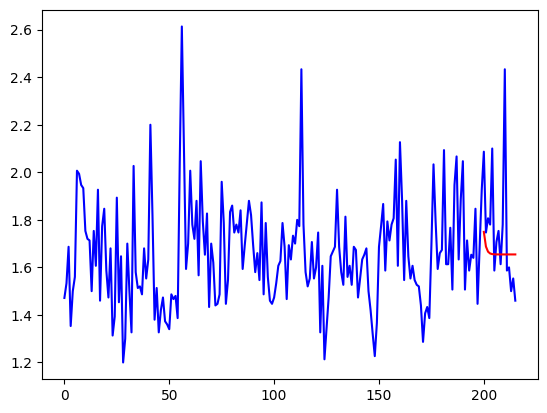

In [34]:
x = np.arange(data.shape[0])
plt.figure()
plt.plot(x, data, c="blue")
plt.plot(x[200:], forecasts, c="red")

##### Model Evaluation

In [35]:
MSE = mean_squared_error(test, forecasts)
print(MSE)

0.06686154465686324
